In [1]:
# default_exp data

# Exploratory Dataset Analysis

In [2]:
#hide
from nbdev.showdoc import *

In [5]:
import warnings
warnings.filterwarnings('ignore')


In [6]:
from nfwk.data import *
from fastai.vision.all import *
from fastai.medical.imaging import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import wandb
assert torch.cuda.is_available()
!pip list | grep "torch\|cuda\|fast"

fastai                        2.4
fastcore                      1.3.20
fastprogress                  1.0.0
fastrelease                   0.1.11
torch                         1.9.0
torchvision                   0.10.0


In [7]:
path = setup('siim-covid19-detection')

In [8]:
train_image_level = pd.read_csv(path/'train_image_level.csv')
train_study_level = pd.read_csv(path/'train_study_level.csv')
sample_submission = pd.read_csv(path/'sample_submission.csv')

In [9]:

# XRAY Files
# Read DICOM files
train_dcm = get_dicom_files(path/'train/', recurse=True)
test_dcm = get_dicom_files(path/'test/', recurse=True)

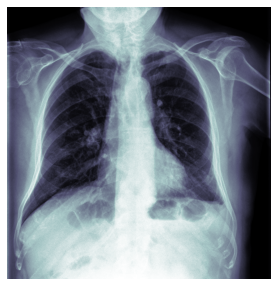

In [80]:
# Looking on a sample XRAY
xray_sample = train_dcm[170].dcmread()
xray_sample.show()

In [15]:
# https://www.kaggle.com/cpmpml/pulmonary-fibrosis-competition-eda-dicom-prep
class bcolors:
    OKBLUE = '\033[96m'
    OKGREEN = '\033[92m'

Patient id.......: a20de80e39c2 
Modality.........: CR 
Rows.............: 2685 
Columns..........: 3000


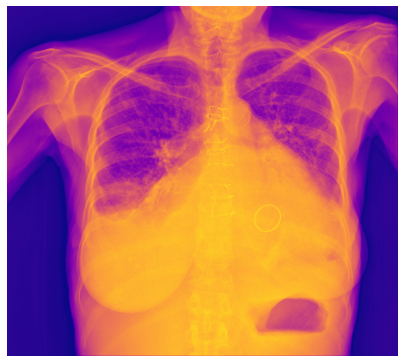

In [79]:
print(bcolors.OKBLUE + "Patient id.......:", xray_sample.PatientID, "\n" +
      "Modality.........:", xray_sample.Modality, "\n" +
      "Rows.............:", xray_sample.Rows, "\n" +
      "Columns..........:", xray_sample.Columns)
plt.figure(figsize = (7, 7))
plt.imshow(xray_sample.pixel_array, cmap="plasma")
plt.axis('off');

In [ ]:
#df_train_dcm = pd.DataFrame.from_dicoms(tqdm(train_dcm))

In [ ]:
#df_test_dcm = pd.DataFrame.from_dicoms(tqdm(test_dcm))

In [ ]:
# with open(path/'df_train_dcm.pickle', 'wb') as handle:
#     pickle.dump(df_train_dcm, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(path/'df_test_dcm.pickle', 'wb') as handle:
#     pickle.dump(df_test_dcm, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open(path/'df_train_dcm.pickle', 'rb') as handle:
    df_train_dcm = pickle.load(handle)
with open(path/'df_test_dcm.pickle', 'rb') as handle:
    df_test_dcm = pickle.load(handle)

In [ ]:
# [host] = !hostname
# host

In [ ]:
# with wandb.init(project='siim-covid19', entity='nido', job_type="pre-process") as run:
#   dfs = wandb.Artifact('siim-covid19-processed', type="data-frame",
#       description=f'Pre-processed data-frames from dataset extracting dicom data.',
#       metadata={"host": host, "path": path})
#   dfs.add_file(path/'df_train_dcm.pickle')
#   dfs.add_file(path/'df_test_dcm.pickle')
#   # ✍️ Save the artifact to W&B.
#   run.log_artifact(dfs)


In [17]:
df_train_dcm = df_train_dcm.drop(columns=['PatientName'])

In [66]:
df_train_dcm.head(1).T

,0
SpecificCharacterSet,ISO_IR 100
ImageType,ORIGINAL
SOPClassUID,71228e4340de
SOPInstanceUID,8cc308497a69
StudyDate,364e93fa20e4
StudyTime,141344daa86e
AccessionNumber,e3fd6138b66d
Modality,DX
PatientID,e7e10bc8f1a4
PatientSex,M


In [160]:
columns = ['DeidentificationMethodCodeSequence', 'DeidentificationMethodCodeSequence1', 'DeidentificationMethodCodeSequence2', 'DeidentificationMethodCodeSequence3', 'DeidentificationMethodCodeSequence4', 'DeidentificationMethodCodeSequence5']
for col in columns:
    df_train_dcm[col]=str(df_train_dcm[col])
    df_test_dcm[col]=str(df_test_dcm[col])

In [162]:
u = df_train_dcm.nunique()
u

SpecificCharacterSet                          2
ImageType                                     2
SOPClassUID                                   2
SOPInstanceUID                             1704
StudyDate                                   192
StudyTime                                  1612
AccessionNumber                            1628
Modality                                      2
PatientID                                  1253
PatientSex                                    2
DeidentificationMethod                        3
DeidentificationMethodCodeSequence            1
BodyPartExamined                             12
ImagerPixelSpacing                           19
StudyInstanceUID                           1628
SeriesInstanceUID                          1704
StudyID                                       7
SeriesNumber                                 27
InstanceNumber                                6
SamplesPerPixel                               1
PhotometricInterpretation               

In [180]:
removable = list(u[u== 1].index) + ['DeidentificationMethod', '','SpecificCharacterSet', 'BitsAllocated']+['ImageType1','ImageType2', 'ImageType3','ImageType4', 'ImageType5']

In [182]:
df_train_dcm = df_train_dcm[df_train_dcm.columns.drop(removable, errors='ignore')]

In [183]:
df_test_dcm = df_test_dcm[df_test_dcm.columns.drop(removable, errors='ignore')]

In [184]:
u = df_train_dcm.nunique()
u

ImageType                       2
SOPClassUID                     2
SOPInstanceUID               1704
StudyDate                     192
StudyTime                    1612
AccessionNumber              1628
Modality                        2
PatientID                    1253
PatientSex                      2
BodyPartExamined               12
ImagerPixelSpacing             19
StudyInstanceUID             1628
SeriesInstanceUID            1704
StudyID                         7
SeriesNumber                   27
InstanceNumber                  6
PhotometricInterpretation       2
Rows                          247
Columns                       253
BitsStored                      7
HighBit                         7
fname                        1704
ImagerPixelSpacing1            19
img_min                       266
img_max                       543
img_mean                     1674
img_std                      1674
img_pct_window               1213
dtype: int64

In [185]:
def show_key_value(key, value):
    l = list(df_train_dcm.loc[df_train_dcm[key] == value].index)
    # Plot the images
    fig=plt.figure(figsize=(16, 6))
    columns = min(10, len(l))
    rows = 1

    for i in range(1, columns*rows +1):
        idx = l[i-1]
        img = train_dcm[idx].dcmread().pixel_array
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap="plasma")
        plt.title(f'{value}: {i}', fontsize = 9)
        plt.axis('off');

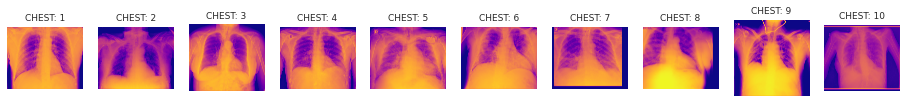

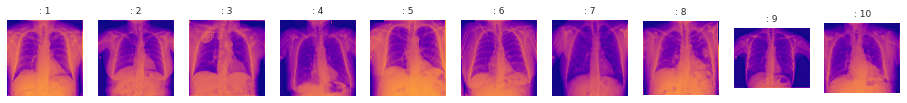

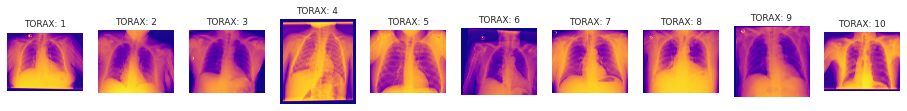

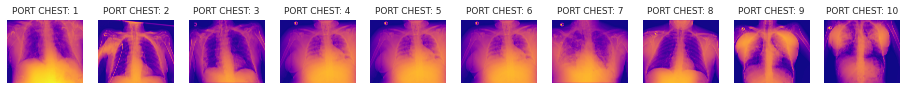

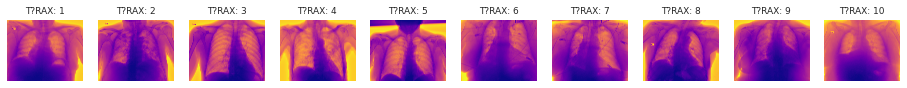

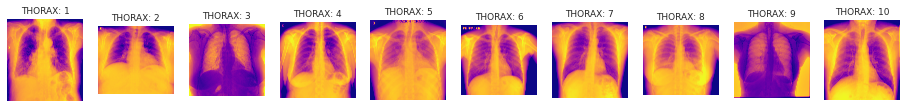

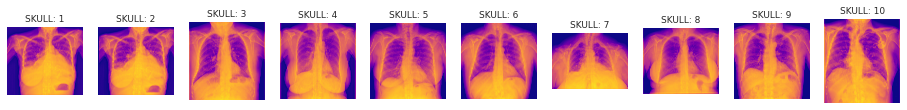

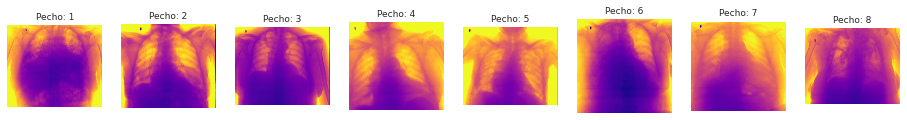

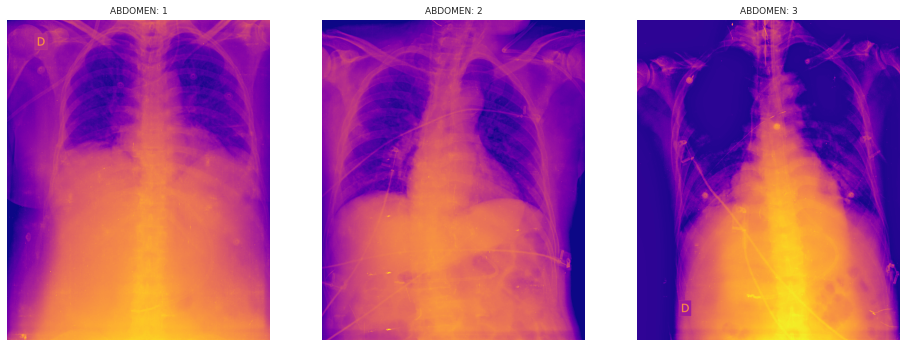

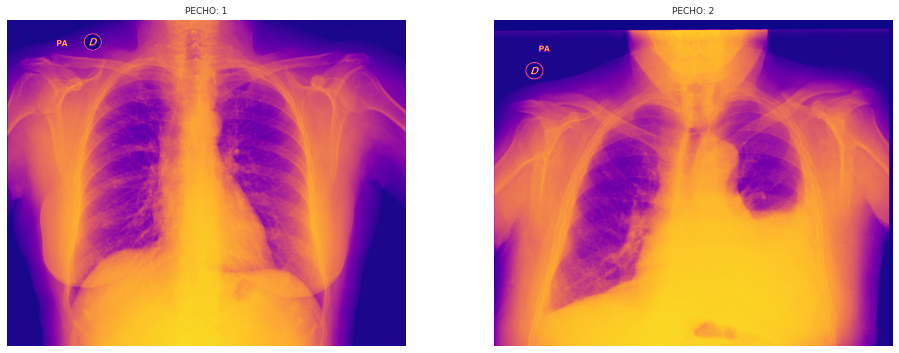

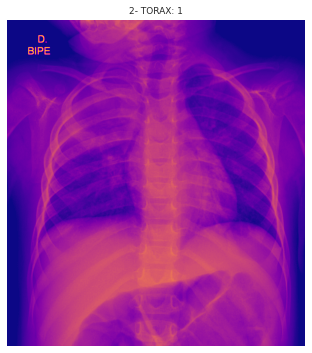

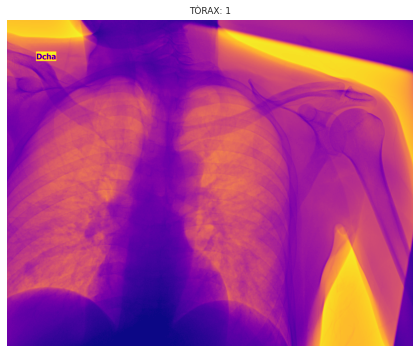

In [186]:
body_parts = list(df_train_dcm['BodyPartExamined'].value_counts().index)
for bp in body_parts: show_key_value('BodyPartExamined', bp)

In [187]:
def missing_data(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    tt.sort_values(by='Percent', ascending=False)
    types = []
    values = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        types.append(dtype)
        vls  = df[col].unique()
        if len(vls)>5: vls = [-1]
        values.append(vls)
    tt['Types'] = types
    tt['Uniques']= values
    return tt.sort_values(by='Percent', ascending=False).T

In [188]:
%%time
missing_data(df_train_dcm).T

CPU times: user 16.4 ms, sys: 17 µs, total: 16.5 ms
Wall time: 16 ms


,Total,Percent,Types,Uniques
InstanceNumber,61,3.579812,float64,[-1]
SeriesNumber,59,3.462441,float64,[-1]
img_pct_window,1,0.058685,float64,[-1]
StudyDate,0,0.0,object,[-1]
PhotometricInterpretation,0,0.0,object,"[MONOCHROME2, MONOCHROME1]"
img_std,0,0.0,float64,[-1]
img_mean,0,0.0,float64,[-1]
img_max,0,0.0,int64,[-1]
img_min,0,0.0,int64,[-1]
ImagerPixelSpacing1,0,0.0,float64,[-1]


In [195]:
df_train_dcm[df_train_dcm.index==1]

,ImageType,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,PatientID,PatientSex,BodyPartExamined,...,Columns,BitsStored,HighBit,fname,ImagerPixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
1,ORIGINAL,03a65300fa41,cafe87118d59,d87b1d7461de,50715b02db1a,d9fee64ad5c3,CR,ab8c45430402,M,CHEST,...,4248,12,11,/home/fred/.fastai/data/siim-covid19-detection/train/33bdeeb50e0f/758e57901460/cafe87118d59.dcm,0.1,0,4095,1638.791839,985.779104,0.0076


In [210]:
row = df_train_dcm[df_train_dcm.index==1]
fname = row['fname']
[fname] = fname.tolist()
fname.split('.')[-2].split('/')[-3:]

['33bdeeb50e0f', '758e57901460', 'cafe87118d59']

In [265]:
def split_fname(df):
    d = df['fname'].apply(lambda x: pd.Series(str(x).split('.')[-2].split('/')[-3:]))
    df['f1']=d[0]
    df['f2']=d[1]
    df['f3']=d[1]
    return df

In [268]:
df_train_dcm = split_fname(df_train_dcm)
df_test_dcm = split_fname(df_train_dcm)

In [273]:
df_train_dcm.head(3)

,ImageType,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,PatientID,PatientSex,BodyPartExamined,...,fname,ImagerPixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,f1,f2,f3
ID,,,,,,,,,,,,,,,,,,,,,
0,ORIGINAL,71228e4340de,8cc308497a69,364e93fa20e4,141344daa86e,e3fd6138b66d,DX,e7e10bc8f1a4,M,CHEST,...,/home/fred/.fastai/data/siim-covid19-detection/train/4453f1641121/262c366dea03/8cc308497a69.dcm,0.100,0,4031,2473.144996,811.761110,0.028633,4453f1641121,262c366dea03,262c366dea03
1,ORIGINAL,03a65300fa41,cafe87118d59,d87b1d7461de,50715b02db1a,d9fee64ad5c3,CR,ab8c45430402,M,CHEST,...,/home/fred/.fastai/data/siim-covid19-detection/train/33bdeeb50e0f/758e57901460/cafe87118d59.dcm,0.100,0,4095,1638.791839,985.779104,0.007600,33bdeeb50e0f,758e57901460,758e57901460
2,ORIGINAL,03a65300fa41,2b58c5262bf9,364e93fa20e4,3e00d6fe4589,ff17f81f3b1d,CR,05eba47b20e3,F,CHEST,...,/home/fred/.fastai/data/siim-covid19-detection/train/85da175299c4/f06b91cbb64e/2b58c5262bf9.dcm,0.143,0,4095,2162.667493,1018.884718,0.006086,85da175299c4,f06b91cbb64e,f06b91cbb64e


In [247]:
d = df_train_dcm['fname']
d = d.rename('fname', inplace=True)
d = d.reset_index()
d = d.drop(columns=['ID'])
d1, d2, d3 = d['fname'].apply(lambda x: pd.Series(str(x).split('.')[-2].split('/')[-3:]))
d['f1']= d1
d['f2']= d2
d['f3']= d3
d

,fname,f1,f2,f3
0,/home/fred/.fastai/data/siim-covid19-detection/train/4453f1641121/262c366dea03/8cc308497a69.dcm,0,1,2
1,/home/fred/.fastai/data/siim-covid19-detection/train/33bdeeb50e0f/758e57901460/cafe87118d59.dcm,0,1,2
2,/home/fred/.fastai/data/siim-covid19-detection/train/85da175299c4/f06b91cbb64e/2b58c5262bf9.dcm,0,1,2
3,/home/fred/.fastai/data/siim-covid19-detection/train/34e9ba075967/5ef4a198159d/ecf80e899d12.dcm,0,1,2
4,/home/fred/.fastai/data/siim-covid19-detection/train/d17a6c6eccdb/fc2bb4e1ffbb/38fd3c9ace4e.dcm,0,1,2
...,...,...,...,...
1699,/home/fred/.fastai/data/siim-covid19-detection/train/a7335b2f9815/b762d1484120/267a250932bc.dcm,0,1,2
1700,/home/fred/.fastai/data/siim-covid19-detection/train/b8fafbc2ad5c/63c0ff673117/c74d0b00b765.dcm,0,1,2
1701,/home/fred/.fastai/data/siim-covid19-detection/train/7b276333034c/a5a3fd6b1c14/419d5f25e84f.dcm,0,1,2
1702,/home/fred/.fastai/data/siim-covid19-detection/train/dcb3c09636ef/cac0b685a214/72e6cd168bd6.dcm,0,1,2


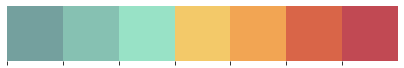

In [19]:
# Set Color Palettes for the notebook
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

In [ ]:
df_train_dcm['img_min']

In [ ]:
df_study = pd.read_csv(path/'train_study_level.csv')
df_study.rename({'id':'study_id',
                      'Negative for Pneumonia':'negative',
                      'Typical Appearance':'typical',
                      'Indeterminate Appearance':'indeterminate',
                      'Atypical Appearance':'atypical'}, axis=1, inplace=True)

In [ ]:
df_study.head(3)

In [ ]:
df_image = pd.read_csv(path/'train_image_level.csv')
df_image['study_id'] = df_image['StudyInstanceUID'].apply(lambda idx: idx+"_study")
df_image.head(1)

In [ ]:
df_annotations = df_image.merge(df_study, on='study_id', how='outer')
df_annotations = df_annotations.drop(columns=['StudyInstanceUID'])
df_annotations['id'] = df_annotations['id'].str.replace('_image', '')
df_annotations.head(1)

In [ ]:
path = setup('')/"train"
path

In [ ]:
files = get_image_files(path)

In [ ]:
files[0]

In [ ]:
len(files)

In [ ]:
def label_func(f):
    return str(f)

In [ ]:
dls = ImageDataLoaders.from_name_func(path, files, label_func=label_func)

In [ ]:
label_func(files[0])

In [ ]:
show_doc(ImageDataLoaders.from_path_func)

In [ ]:
dls = ImageDataLoaders.from_path_func(path, files, label_func).cuda()


In [ ]:
dls.show_batch()

In [ ]:
fnmsTrain = !ls $path/"train"
lbls = pd.DataFrame([label_func(n) for n in fnmsTrain])
pd.DataFrame.value_counts(lbls)

In [ ]:
lbls.describe()